In [1]:
import os
import time
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.utils import class_weight

In [2]:
x = np.load("C:/Users/Izabela/Desktop/sign_language_digits/X.npy")
y = np.load("C:/Users/Izabela/Desktop/sign_language_digits/Y.npy")

(-0.5, 63.5, 63.5, -0.5)

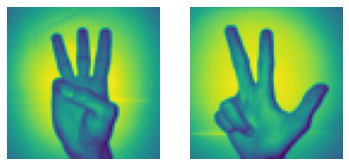

In [3]:
img_size = 64
plt.subplot(1,2,1)
plt.imshow(x[700].reshape(img_size,img_size))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(x[1500].reshape(img_size,img_size))
plt.axis('off')

In [4]:
# As you can see, y (labels) are already one hot encoded
print(y.max())
print(y.min())
print(y.shape)

# And x (features) are already scaled between 0 and 1
print(x.max())
print(x.min())
print(x.shape)

1.0
0.0
(2062, 10)
1.0
0.003921569
(2062, 64, 64)


In [5]:
# Now,lets create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
#reshape
x_train = x_train.reshape(-1,64,64,1)
x_test = x_test.reshape(-1,64,64,1)
#print x_train and y_train shape
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1649, 64, 64, 1)
(1649, 10)
(413, 64, 64, 1)
(413, 10)


In [6]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (64,64,1)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))


# fully connected
model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [7]:
def get_checkpoint(model_name):
    checkpoint_path = 'checkpoints/' + model_name + '-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
    return ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

In [9]:
import tensorflow as tf
optimizer2 = tf.keras.optimizers.RMSprop()
#from tf.keras.optimizers import RMSprop,Adam

# Define the optimizer
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
#optimizer2 = keras.optimizers.RMSprop(lr=0.0001)
optimizers = [optimizer, optimizer2]

In [10]:


# Helper Functions  Learning Curves and Confusion Matrix

#from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, checkpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)



Epoch 1/100
42/42 [==============================] - 6s 113ms/step - loss: 2.3091 - accuracy: 0.1069 - val_loss: 2.3027 - val_accuracy: 0.0909
Epoch 2/100
42/42 [==============================] - 5s 108ms/step - loss: 2.3026 - accuracy: 0.1084 - val_loss: 2.3025 - val_accuracy: 0.1121
Epoch 3/100
42/42 [==============================] - 4s 106ms/step - loss: 2.3022 - accuracy: 0.1114 - val_loss: 2.3026 - val_accuracy: 0.0879
Epoch 4/100
42/42 [==============================] - 5s 108ms/step - loss: 2.3015 - accuracy: 0.1114 - val_loss: 2.3032 - val_accuracy: 0.0879
Epoch 5/100
42/42 [==============================] - 4s 104ms/step - loss: 2.2950 - accuracy: 0.1289 - val_loss: 2.2932 - val_accuracy: 0.1121
Epoch 6/100
42/42 [==============================] - 4s 104ms/step - loss: 2.0184 - accuracy: 0.2563 - val_loss: 1.7690 - val_accuracy: 0.2970
Epoch 7/100
42/42 [==============================] - 4s 104ms/step - loss: 1.3930 - accuracy: 0.5186 - val_loss: 1.0711 - val_accuracy: 0.6727

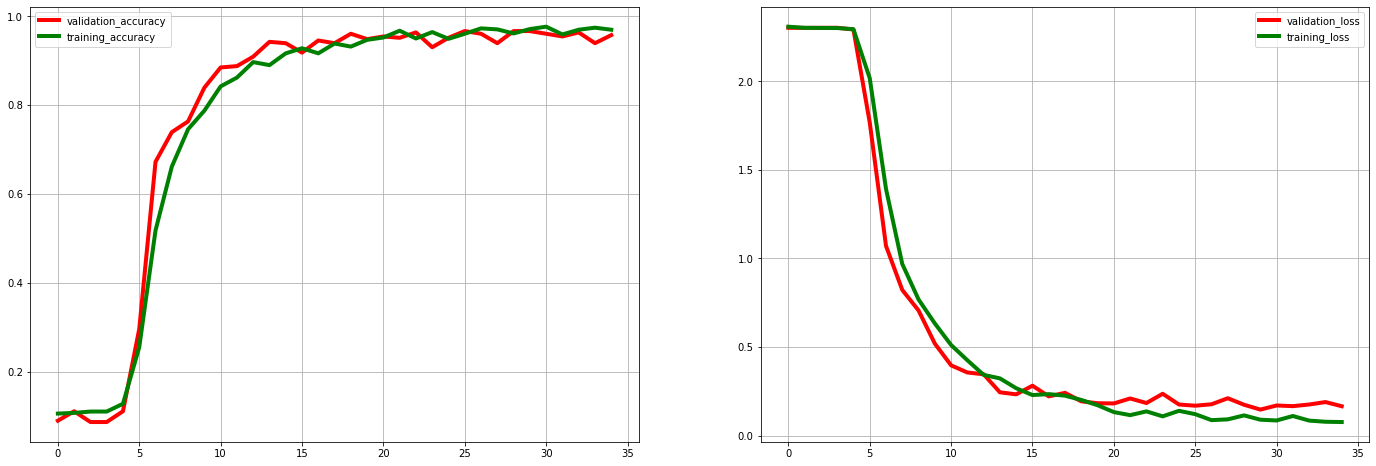

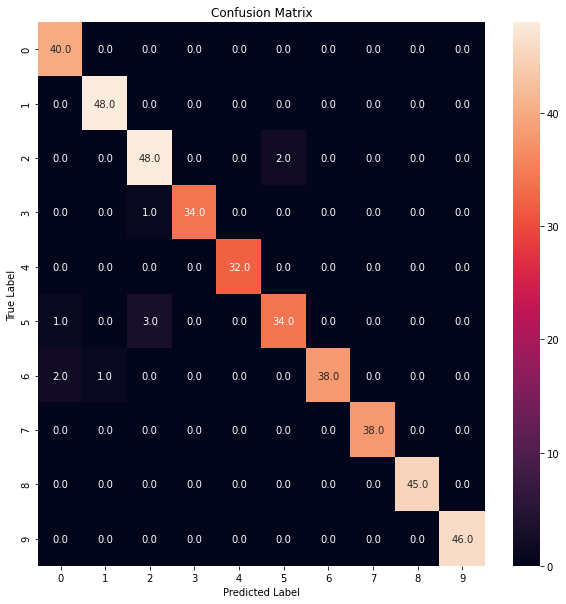

<Figure size 432x288 with 0 Axes>

Epoch 1/100
42/42 [==============================] - 6s 112ms/step - loss: 0.0996 - accuracy: 0.9621 - val_loss: 0.1829 - val_accuracy: 0.9606
Epoch 2/100
42/42 [==============================] - 4s 104ms/step - loss: 0.0737 - accuracy: 0.9712 - val_loss: 0.2075 - val_accuracy: 0.9485
Epoch 3/100
42/42 [==============================] - 4s 104ms/step - loss: 0.0550 - accuracy: 0.9833 - val_loss: 0.1904 - val_accuracy: 0.9667
Epoch 4/100
42/42 [==============================] - 4s 104ms/step - loss: 0.0677 - accuracy: 0.9750 - val_loss: 0.2033 - val_accuracy: 0.9606
Epoch 5/100
42/42 [==============================] - 4s 104ms/step - loss: 0.1251 - accuracy: 0.9591 - val_loss: 0.1897 - val_accuracy: 0.9606
Epoch 6/100
42/42 [==============================] - 4s 103ms/step - loss: 0.0675 - accuracy: 0.9780 - val_loss: 0.1822 - val_accuracy: 0.9636
Epoch 7/100
42/42 [==============================] - 4s 103ms/step - loss: 0.0558 - accuracy: 0.9780 - val_loss: 0.1841 - val_accuracy: 0.9758

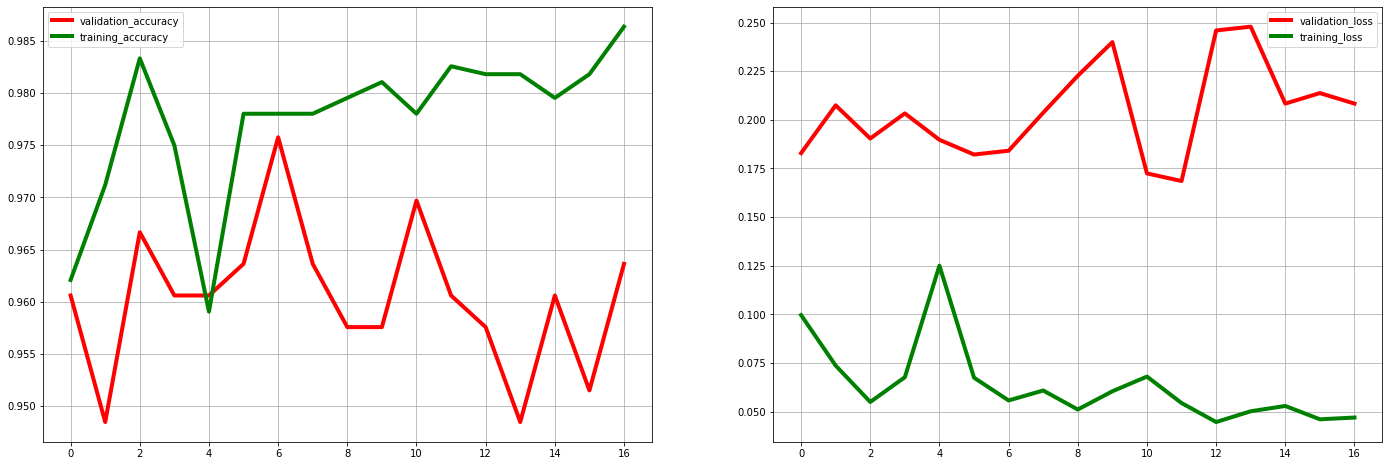

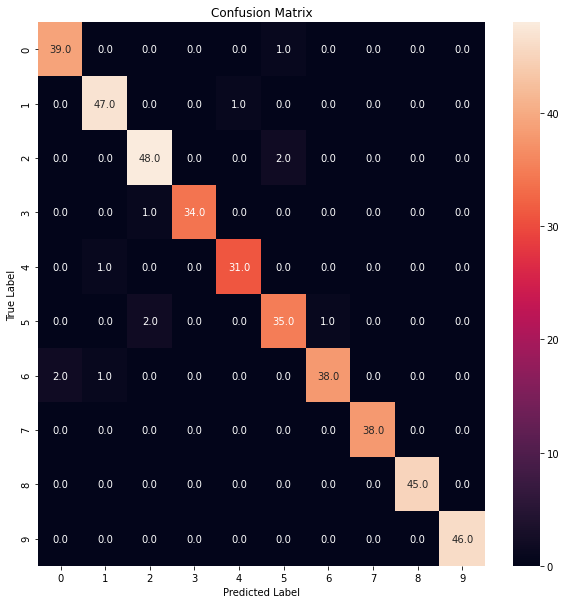

<Figure size 432x288 with 0 Axes>

In [11]:
for opt in optimizers:
    model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics=["accuracy"])


    early_stopping = EarlyStopping(patience=5, monitor="val_loss")

    history = model.fit(x_train,y_train,validation_split = 0.2, epochs=100,callbacks=[MetricsCheckpoint('logs'),early_stopping])
    
    score = model.evaluate(x_test,y_test, verbose=0)
    
    print('\nKeras CNN - accuracy:', score[1], '\n')
    plt.figure(figsize=(24,8))

    plt.subplot(1,2,1)
    plt.plot(history.history["val_accuracy"], label="validation_accuracy", c="red", linewidth=4)
    plt.plot(history.history["accuracy"], label="training_accuracy", c="green", linewidth=4)
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history["val_loss"], label="validation_loss", c="red", linewidth=4)
    plt.plot(history.history["loss"], label="training_loss", c="green", linewidth=4)
    plt.legend()
    plt.grid(True)
    y_predict = model.predict(x_test)
    y_predict_classes = np.argmax(y_predict,axis = 1) 
    y_true = np.argmax(y_test,axis = 1) 
    confusion_mtx = confusion_matrix(y_true, y_predict_classes) 
    plt.figure(figsize = (10,10))
    sns.heatmap(confusion_mtx, annot=True,fmt= '.1f')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    plt.suptitle("ACC / LOSS",fontsize=18)

    plt.show()